In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '7'

In [2]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import sys
sys.path.append('/home/mei/nas/docker/thesis/model_train')
from torch.utils.data import DataLoader

from dataloader.ts_reader import MultiModalDataset, collate_fn
from dataloader.pyg_reader import GraphDataset
from model.loss_train_final import *
from model.final_model import PatientOutcomeModel
from model.autoencoder_ts import RecurrentAutoencoder

import pickle
from sklearn.manifold import TSNE
import numpy as np 


In [3]:
import gc
gc.collect()

torch.cuda.empty_cache()
torch.cuda.synchronize()

from torch.amp import GradScaler, autocast
scaler = GradScaler() 

In [4]:
# === LSTM + Flat Dataset ===
train_data_dir = "/home/mei/nas/docker/thesis/data/hdf/train"
val_data_dir = "/home/mei/nas/docker/thesis/data/hdf/val"
test_data_dir = "/home/mei/nas/docker/thesis/data/hdf/test"

lstm_dataset_train = MultiModalDataset(train_data_dir)
lstm_dataset_val = MultiModalDataset(val_data_dir)
lstm_dataset_test = MultiModalDataset(test_data_dir)

train_loader = DataLoader(lstm_dataset_train , batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(lstm_dataset_val , batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(lstm_dataset_test , batch_size=32, shuffle=False, collate_fn=collate_fn)

config = {  
    "data_dir": "/home/mei/nas/docker/thesis/data/hdf",
    "graph_dir": "/home/mei/nas/docker/thesis/data/graphs",
    "mode": "k_closest",
    "k": 3         
}
graph_dataset = GraphDataset(config)


==> Loading precomputed graph from /home/mei/nas/docker/thesis/data/graphs/diagnosis_graph_k_closest_k3.pt
==> Loading flat features from /home/mei/nas/docker/thesis/data/hdf/final_flat.h5


In [5]:
save_path = '/home/mei/nas/docker/thesis/data/model_results/final_model/best_model.pth'
history_path = '/home/mei/nas/docker/thesis/data/model_results/final_model/history.json'

flat_input_dim = 104
# ts_input_dim = 154
hidden_dim = 128
graph_input_dim = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


pretrained_encoder = RecurrentAutoencoder(n_features=154, embedding_dim=128,n_heads=2).to(device)
pretrained_encoder.load_state_dict(torch.load("/home/mei/nas/docker/thesis/data/model_results/pre_train/best_model_2.pth",weights_only=True ))
pretrained_encoder = pretrained_encoder.encoder

model = PatientOutcomeModel(flat_input_dim,graph_input_dim, hidden_dim,pretrained_encoder=pretrained_encoder).to(device)   
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [6]:
model,history = train_patient_outcome_model(model, train_loader, val_loader, graph_dataset.graph_data,optimizer, device, n_epochs=150, save_path=save_path, history_path=history_path,patience=50)

Epoch 10: Train 0.0069, Val 0.0078
Epoch 20: Train 0.0056, Val 0.0075
Epoch 30: Train 0.0048, Val 0.0077
Epoch 40: Train 0.0040, Val 0.0079
Epoch 50: Train 0.0033, Val 0.0081
Epoch 60: Train 0.0027, Val 0.0085
Epoch 70: Train 0.0022, Val 0.0094
Early stopping triggered.


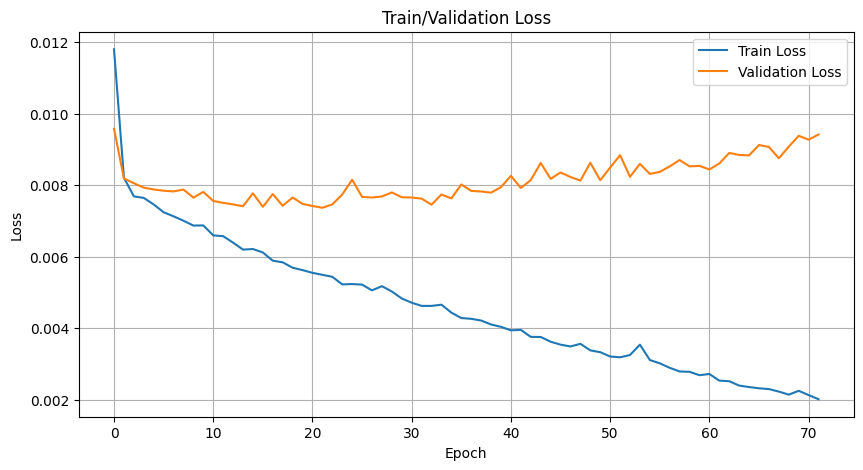

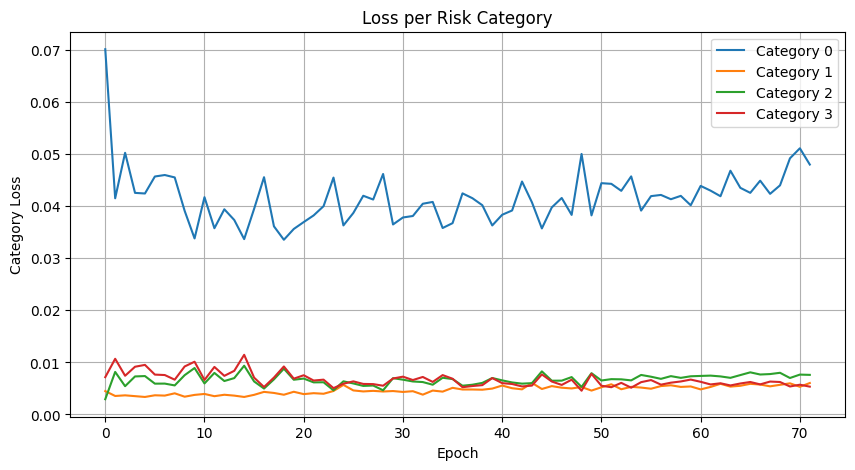

In [7]:
plot_training_history(history)

In [6]:
model.load_state_dict(torch.load('/home/mei/nas/docker/thesis/data/model_results/final_model/best_model.pth',weights_only=True))
result = evaluate_model_on_test_set(model, test_loader, graph_dataset.graph_data, device)



Test Evaluation Summary:
  Risk Category 0: Mean Loss = 0.0337, Count = 27
  Risk Category 1: Mean Loss = 0.0058, Count = 294
  Risk Category 2: Mean Loss = 0.0070, Count = 89
  Risk Category 3: Mean Loss = 0.0058, Count = 51


In [9]:
plot_patient_risk_trajectory(model, test_loader, patient_index=3, graph_data=graph_dataset.graph_data, device=device)


TypeError: 'DataLoader' object is not subscriptable